In [1]:
import pandas as pd
import pickle
from sportsreference.ncaab.teams import Teams
from sportsreference.ncaab.conferences import Conferences
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import poisson
from scipy.optimize import minimize


In [2]:
import logging
import os
import torch
from matplotlib import rc
import matplotlib
import pyro

import argparse

import pyro.distributions as dist

from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.optim import ClippedAdam
from torch.distributions import constraints
from utils import plot_quality, score_table
from bokeh.plotting import figure, show, output_file,  output_notebook

I am gonna just try to get the following data for 2020-2021 season for NCAA basketball:
```
Date, HomeTeam, AwayTeam, HP, AP
```
Then I am gonna try to reproduce [this analysis](http://www.pena.lt/y/2021/06/18/predicting-football-results-using-the-poisson-distribution/).

Then I will try to recode the analysis in Pyro.

Then I will try to modify it.

Perhaps focus on the second half over under. So I will need the first half and second half totals. 

Some notes on modeling:
- I could just focus on the point spead and use a linear model. 
- I could use a binomial regression; no stick with poisson
- I think I need to try a bunch of simple models and show how easy it is to do in Pyro
- I think I should start with just fitting a poisson to each team
- the good thing about a generative model is that you can calculate outcomes of prop bets such as the outcome of the first half
- I think adding in defense and offense factors into the poisson regression makes sense
- I think training on only away games could also make sense; or including the factor for home or away but then setting it to "away" for the tournament games. The latter makes more sense. I will need a feature for home, one for away, and if they are both off that is a neutral site
- I could move to a hierarchical model with the intercept decided by the conference. So I have a linear relation between the conference
- The model from Pena.lt/y uses a linear combination of offense, defense, and home advantage but exponentiates it and this gives different probabilities. Not sure why they do this.

Some notes on data munging:
- I might want to drop all games where the opponent is not in one of the big conferences (opponent_conference in ...)
- Most games will be listed twice: once for the home team, once for the away team. Thus, I will need to drop one of them for some modeling setups (ie., the boxscore_index needs to be unique).




In [3]:
majorConfs = ["big-12","Big 12",
              "big-10","Big Ten","big-ten",
              "sec","SEC",
              "big-east","Big East",
              "pac-12","PAC-12",
              "acc","ACC",
              "wcc", "WCC"]
def getDataForTeams(teams) :
    dataset = pd.DataFrame()
    for team in teams:
        if team.conference in majorConfs:
            tgDF = team.schedule.dataframe
            tgDF['team_name'] = team.name
            tgDF['team_conference'] = team.conference
            dataset = pd.concat([dataset,tgDF])     
    return dataset



In [41]:
#execute this cell to grab the data from the site
season_team_list = Teams("2021")
df = getDataForTeams(season_team_list)
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df.to_csv('data/bigconfs2021Season.zip', compression=compression_opts) 
pickle.dump( season_team_list, open( "data/teams2021.p", "wb" ) )

In [4]:
#execute this cell to just load the local files
season_team_list = pickle.load( open( "data/teams2021.p", "rb" ) )
c_opts = dict(method='zip')
df = pd.read_csv('data/bigconfs2021Season.zip',compression='zip')

In [5]:
#some access functions practice
type(season_team_list)
t = next(iter(season_team_list))
[t.name, t.conference]
game = next(iter(t.schedule))
type(game)

sportsreference.ncaab.schedule.Game

In [6]:
bdf = df
#only have games between big conferences
bdf = bdf[bdf["opponent_conference"].isin(majorConfs)]
#get rid of duplicates
bdf.drop_duplicates(subset='boxscore_index', keep="first")
#drop Neutral games for now
bdf = bdf[bdf["location"].isin(["Home","Away"])]
#create Home, Away, neutral indicator columns
bdf = pd.get_dummies(bdf,prefix=['location'], columns = ['location'])
#create homeTeam, awayTeam columns
def addHomeTeamColumn(row):
    if(row['location_Home'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['HomeTeam'] = bdf.apply(addHomeTeamColumn, axis=1)
def addAwayTeamColumn(row):
    if(row['location_Away'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['AwayTeam'] = bdf.apply(addAwayTeamColumn, axis=1)
#add in "HomePoints" , AwayPoints
def addHomePointsColumn(row):
    if(row['location_Home'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['HomePoints'] = bdf.apply(addHomePointsColumn, axis=1)
def addAwayPointsColumn(row):
    if(row['location_Away'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['AwayPoints'] = bdf.apply(addAwayPointsColumn, axis=1)
#just big ten conference games
big10df = bdf.loc[(bdf["team_conference"]=='big-ten')&
                  (bdf['opponent_conference']=='Big Ten')]

#rename columns
selector_d = {'date':'Date', 'HomeTeam':'HomeTeam', 'AwayTeam':'AwayTeam',
              'HomePoints':'FTHG', 'AwayPoints':'FTAG'}
bdf = bdf.rename(columns=selector_d)[selector_d.values()]
bdf.reset_index(inplace=True, drop=True)
big10df = big10df.rename(columns=selector_d)[selector_d.values()]
big10df.reset_index(inplace=True, drop=True)
bdf.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,"Tue, Dec 29, 2020",Alabama,Mississippi,82.0,64.0
1,"Sat, Jan 2, 2021",Tennessee,Alabama,63.0,71.0
2,"Tue, Jan 5, 2021",Alabama,Florida,86.0,71.0
3,"Sat, Jan 9, 2021",Auburn,Alabama,90.0,94.0
4,"Tue, Jan 12, 2021",Kentucky,Alabama,65.0,85.0


In [7]:
big10df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,"Tue, Dec 15, 2020",Illinois,Minnesota,92.0,65.0
1,"Sun, Dec 20, 2020",Rutgers,Illinois,91.0,88.0
2,"Wed, Dec 23, 2020",Penn State,Illinois,81.0,98.0
3,"Sat, Dec 26, 2020",Illinois,Indiana,69.0,60.0
4,"Sat, Jan 2, 2021",Illinois,Purdue,66.0,58.0


In [11]:
len(big10df.index)

272

In [12]:
#figure out how many teams there are and half them, could do it by conference
  #each team is playing around 40 games 
#try the other penalty code
len(df.loc[df['opponent_conference']=='Big Ten'].opponent_name.unique())

14

In [13]:
df.iloc[[8]]

,Unnamed: 0,arena,boxscore_index,date,datetime,game,location,opponent_abbr,opponent_conference,opponent_name,...,points_against,points_for,result,season_losses,season_wins,streak,time,type,team_name,team_conference
8,2020-12-29-21-alabama,Coleman Coliseum,2020-12-29-21-alabama,"Tue, Dec 29, 2020",2020-12-29 21:00:00,9,Home,mississippi,SEC,Mississippi,...,64.0,82.0,Win,3.0,6.0,W 2,9:00p,Reg,Alabama,sec


In [14]:
homeMean = df[df.location=='Home']['points_for'].mean()
awayMean = df[df.location=='Away']['points_for'].mean()
[homeMean,awayMean]

[74.85714285714286, 69.88300492610837]

In [15]:
df[df.location=='Home']['points_for'].max()

142.0

Text(0.5, 1.0, 'Number of Points Scored Per Game')

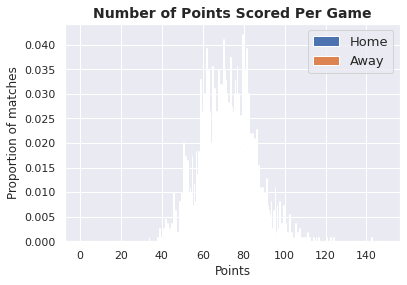

In [8]:

sns.set()

max_goals = 150
homeAwayPtsArray = df[df.location=='Home'][['points_for','points_against']].values
plt.hist(homeAwayPtsArray, range(max_goals), label=["Home", "Away"], density=True
)
#plt.xticks([i - 0.5 for i in range(max_goals)], [i for i in range(max_goals)])
plt.xlabel("Points")
plt.ylabel("Proportion of matches")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of Points Scored Per Game", size=14, fontweight="bold")

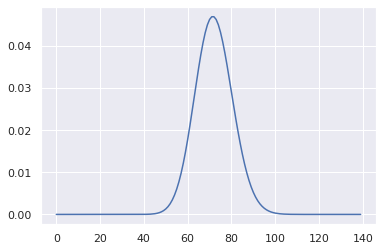

In [14]:
# importing poisson from scipy
from scipy.stats import poisson
 
# importing numpy as np
import numpy as np
 
# importing matplotlib as plt
import matplotlib.pyplot as plt
 
 
# creating a numpy array for x-axis
# using step size as 1
x = np.arange(0, 140, 1)
 
# poisson distribution data for y-axis
y = poisson.pmf(x, mu=72, loc=0)
 
 
# plotting the graph
plt.plot(x, y)
 
# showing the graph
plt.show()

Text(0.5, 1.0, 'Number of Points Scored Per Game')

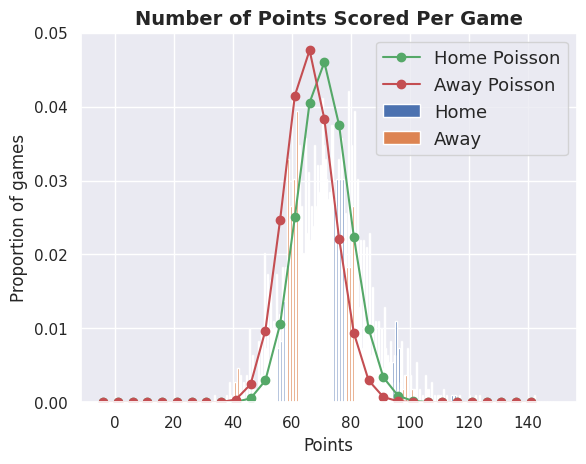

In [23]:

home_poisson = poisson.pmf(range(0,max_goals,5), homeMean)
away_poisson = poisson.pmf(range(0,max_goals,5), awayMean)

plt.hist(
    homeAwayPtsArray, range(max_goals), label=["Home", "Away"], density=True
)

pts = [i - 5 for i in range(1, max_goals + 1,5)]
plt.plot(
    pts,
    home_poisson,
    linestyle="-",
    marker="o",
    label="Home Poisson",
)

plt.plot(
    pts,
    away_poisson,
    linestyle="-",
    marker="o",
    label="Away Poisson",
)


#plt.xticks([i - 0.5 for i in range(1, max_goals + 1)], [i for i in range(max_goals)])
plt.xlabel("Points")
plt.ylabel("Proportion of games")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of Points Scored Per Game", size=14, fontweight="bold")


In [15]:
#this is data for soccer (20 teams with 38 games per team)
#df = pd.read_csv("https://www.football-data.co.uk/mmz4281/1718/E0.csv")
#df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]].head()

In [16]:
#dff = pd.read_csv("https://www.football-data.co.uk/mmz4281/1718/E0.csv")
#dff[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]].head()
#dff.loc[dff["AwayTeam"]=="Arsenal"]

In [52]:
#this is the log likelihood of the first two things happening
def log_likelihood(
    goals_home_observed, #will serve as k
    goals_away_observed, #will serve as k
    home_attack,
    home_defence,
    away_attack,
    away_defence,
    home_advantage,
):
    #these will serve as mu
    goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)
    #goal_expectation_home = home_attack + away_defence + home_advantage
    #goal_expectation_away = away_attack + home_defence

    if goal_expectation_home < 0 or goal_expectation_away < 0:
        return 10000    
    #(k,mu)
    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)

    #probability of both teams' scores
    log_llk = np.log(home_llk) + np.log(away_llk)

    return -log_llk

def predict(home_team, away_team, params, max_goals=10):
    home_attack = params["attack_" + home_team]
    home_defence = params["defence_" + home_team]
    away_attack = params["attack_" + away_team]
    away_defence = params["defence_" + away_team]
    home_advantage = params["home_adv"]

    home_goal_expectation = np.exp(home_attack + away_defence + home_advantage)
    away_goal_expectation = np.exp(away_attack + home_defence)
    #home_goal_expectation = home_attack + away_defence + home_advantage
    #away_goal_expectation = away_attack + home_defence

    home_probs = poisson.pmf(list(range(max_goals + 1)), home_goal_expectation)
    away_probs = poisson.pmf(range(max_goals + 1), away_goal_expectation)

    probability_matrix = np.outer(home_probs, away_probs)

    return probability_matrix

In [54]:
    teams = np.sort(np.unique(np.concatenate([big10df["HomeTeam"], big10df["AwayTeam"]])))
    n_teams = len(teams)
    n_teams

14

In [58]:


def fit_poisson_model():
    teams = np.sort(np.unique(np.concatenate([big10df["HomeTeam"], big10df["AwayTeam"]])))
    n_teams = len(teams)

    params = np.concatenate(
        (
            np.random.uniform(0.5, 1.5, (n_teams)),  # attack strength
            np.random.uniform(0, -1, (n_teams)),  # defence strength
            [0.25],  # home advantage
        )
    )

    def _fit(params, big10df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-1]

        llk = list()
        for idx, row in big10df.iterrows():
            tmp = log_likelihood(
                row["FTHG"],
                row["FTAG"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 100,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(big10df, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv"],
            res["x"],
        )
    )

    return model_params


In [59]:
model_params = fit_poisson_model()

<ipython-input-52-5cbeff422d04>:12: RuntimeWarning: overflow encountered in exp
  goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
<ipython-input-52-5cbeff422d04>:13: RuntimeWarning: overflow encountered in exp
  goal_expectation_away = np.exp(away_attack + home_defence)
/usr/local/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:602: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu
<ipython-input-52-5cbeff422d04>:24: RuntimeWarning: divide by zero encountered in log
  log_llk = np.log(home_llk) + np.log(away_llk)


In [60]:
model_params

{'attack_Illinois': 1.1038160799888805,
 'attack_Indiana': 0.9940284375105868,
 'attack_Iowa': 1.1353081431615044,
 'attack_Maryland': 0.9137974778511287,
 'attack_Michigan': 1.048765029718904,
 'attack_Michigan State': 0.9223533554069858,
 'attack_Minnesota': 0.9949441937275093,
 'attack_Nebraska': 0.9461303406330838,
 'attack_Northwestern': 0.9537464656807302,
 'attack_Ohio State': 1.0812017732871446,
 'attack_Penn State': 1.0192138902008179,
 'attack_Purdue': 0.978285219156053,
 'attack_Rutgers': 0.9626293046816512,
 'attack_Wisconsin': 0.9457802889950179,
 'defence_Illinois': 3.219011748328226,
 'defence_Indiana': 3.264272079488492,
 'defence_Iowa': 3.267172820459021,
 'defence_Maryland': 3.1672538493484494,
 'defence_Michigan': 3.1542972195516543,
 'defence_Michigan State': 3.217662608940059,
 'defence_Minnesota': 3.2916600934619646,
 'defence_Nebraska': 3.310672134944848,
 'defence_Northwestern': 3.2591292922406163,
 'defence_Ohio State': 3.2457931094829853,
 'defence_Penn State'

In [65]:
probs = predict("Michigan", "Michigan State", model_params, 100)
print(probs)

[[1.62049516e-58 9.55244593e-57 2.81547348e-55 ... 5.50846399e-39
  3.27991183e-39 1.93343252e-39]
 [1.20110300e-56 7.08022570e-55 2.08681503e-53 ... 4.08284628e-37
  2.43105444e-37 1.43305063e-37]
 [4.45125805e-55 2.62391415e-53 7.73368493e-52 ... 1.51309274e-35
  9.00942767e-36 5.31085021e-36]
 ...
 [3.08081550e-29 1.81606981e-27 5.35265674e-26 ... 1.04724541e-09
  6.23562690e-10 3.67575851e-10]
 [2.30655073e-29 1.35965856e-27 4.00743709e-26 ... 7.84053661e-10
  4.66850084e-10 2.75197378e-10]
 [1.70960400e-29 1.00777220e-27 2.97029256e-26 ... 5.81136698e-10
  3.46026975e-10 2.03974936e-10]]


In [66]:
#draw
np.sum(np.diag(probs))

0.014583127697213837

In [67]:
#home win
np.sum(np.tril(probs, -1))

0.8969129597190542

In [68]:
# away win
np.sum(np.triu(probs, 1))

0.08677249615287969

In [71]:
import penaltyblog as pb

In [74]:
pois = pb.poisson.PoissonGoalsModel(
    big10df["FTHG"], big10df["FTAG"], big10df["HomeTeam"], big10df["AwayTeam"])
pois.fit()
pois

Module: Penaltyblog

Model: Poisson

Number of parameters: 29
Log Likelihood: -2480.425
AIC: 5018.849

Team                 Attack               Defence             
------------------------------------------------------------
Illinois             1.13                 3.0                 
Indiana              0.98                 3.0                 
Iowa                 1.153                3.0                 
Maryland             0.898                3.0                 
Michigan             1.032                3.0                 
Michigan State       0.918                3.0                 
Minnesota            0.988                3.0                 
Nebraska             0.936                3.0                 
Northwestern         0.949                3.0                 
Ohio State           1.092                3.0                 
Penn State           1.016                3.0                 
Purdue               0.988                3.0                 
Rutgers          

In [76]:
probs = pois.predict("Michigan", "Michigan State")
probs

Module: Penaltyblog

Class: FootballProbabilityGrid

Home Goal Expectation: 73.84954803312031
Away Goal Expectation: 50.301602574423256

Home Win: 5.912390535010854e-27
Draw: 1.597342675596718e-26
Away Win: 3.645450321926655e-27

In [83]:
probs = pois.predict("Michigan", "Michigan State", max_goals=90)
probs

Module: Penaltyblog

Class: FootballProbabilityGrid

Home Goal Expectation: 73.84954803312031
Away Goal Expectation: 50.301602574423256

Home Win: 0.9436566054505039
Draw: 0.0037985258241342267
Away Win: 0.015066976198701391

In [82]:
#figure out how they get the Home Goal Expectation 
#by taking the parameters and trying to push it into the formula for mu 
# since the mean, the variance, and the expected value are all equal
home_goal_exp = np.exp(1.032 + 3 + 0.27)
away_goal_exp = np.exp(0.918 + 3)
[home_goal_exp,away_goal_exp]

[73.84734078489791, 50.29974462223191]

In [84]:
probs.total_goals("over", 120)

0.5858817725318181

In [85]:
probs.total_goals("under", 120)

0.34272312421499823

In [81]:
pb.ratings.massey(big10df["FTHG"], big10df["FTAG"], big10df["HomeTeam"], big10df["AwayTeam"])

,team,rating,offence,defence
0,Michigan,8.54959,38.5533,-30.0037
1,Illinois,8.32537,42.7004,-34.3751
2,Iowa,7.35951,45.1267,-37.7672
3,Ohio State,4.62727,40.8765,-36.2493
4,Purdue,2.86802,33.3624,-30.4944
5,Wisconsin,0.904783,31.2398,-30.335
6,Rutgers,-0.930105,32.358,-33.2881
7,Maryland,-1.46668,29.2849,-30.7516
8,Penn State,-2.32984,36.2435,-38.5733
9,Indiana,-2.92488,34.5989,-37.5238


In [86]:
#what if I just scaled the goals somehow? 
# subtracted min-2 (37-2)
#df['new'] = df['hb'] - 5
# divided by 25 ; I won't get an integer count
big10df.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'], dtype='object')

In [87]:
big10df.FTHG.describe()

count    272.000000
mean      71.698529
std       10.468240
min       48.000000
25%       64.000000
50%       72.000000
75%       79.000000
max      102.000000
Name: FTHG, dtype: float64

In [88]:
big10df.FTAG.describe()

count    272.000000
mean      68.801471
std       11.396782
min       37.000000
25%       60.000000
50%       68.000000
75%       75.250000
max       98.000000
Name: FTAG, dtype: float64

In [90]:
big10df['newFTAG'] = big10df['FTAG'] - 35

big10df['newFTHG'] = big10df['FTHG'] - 35

In [107]:
big10df['newFTAG'] = big10df['FTAG'] / 35.0

big10df['newFTHG'] = big10df['FTHG'] / 35.0

In [108]:
big10df.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'newFTAG', 'newFTHG'], dtype='object')

In [109]:
big10minus35df = big10df[['Date', 'HomeTeam', 'AwayTeam', 'newFTAG', 'newFTHG']]
selector_d = {'Date':'Date', 'HomeTeam':'HomeTeam', 'AwayTeam':'AwayTeam',
              'newFTHG':'FTHG', 'newFTAG':'FTAG'}
big10minus35df = big10minus35df.rename(columns=selector_d)[selector_d.values()]
big10minus35df.reset_index(inplace=True, drop=True)

In [110]:
big10minus35df.FTAG.describe()

count    272.000000
mean       1.965756
std        0.325622
min        1.057143
25%        1.714286
50%        1.942857
75%        2.150000
max        2.800000
Name: FTAG, dtype: float64

In [111]:
poisMinus35 = pb.poisson.PoissonGoalsModel(
    big10minus35df["FTHG"], big10minus35df["FTAG"], big10minus35df["HomeTeam"], big10minus35df["AwayTeam"])
poisMinus35.fit()
poisMinus35

Module: Penaltyblog

Model: Poisson

Number of parameters: 29
Log Likelihood: -670.631
AIC: 1399.262

Team                 Attack               Defence             
------------------------------------------------------------
Illinois             1.173                -0.693              
Indiana              0.975                -0.528              
Iowa                 1.185                -0.581              
Maryland             0.83                 -0.738              
Michigan             1.072                -0.753              
Michigan State       0.876                -0.62               
Minnesota            1.033                -0.547              
Nebraska             0.978                -0.513              
Northwestern         1.0                  -0.6                
Ohio State           1.111                -0.606              
Penn State           1.017                -0.551              
Purdue               0.993                -0.723              
Rutgers           

In [112]:
probs = poisMinus35.predict("Michigan", "Michigan State", max_goals=70)
probs

Module: Penaltyblog

Class: FootballProbabilityGrid

Home Goal Expectation: 1.6868021621172717
Away Goal Expectation: 1.1310448438226437

Home Win: 0.5035834355383367
Draw: 0.24106257634236378
Away Win: 0.2553539881192995

In [113]:
probs.total_goals("under", 2)

0.22805684675764631

In [114]:
[1.6868021621172717*35,1.1310448438226437*35]

[59.03807567410451, 39.58656953379253]

# This is the Pyro code!!!
copied from Theo Rashid (Pyro:a guide to winning the Premier League)


In [8]:
def transformData(data):
    pl_data = data

    ng = len(pl_data)  # number of games
    npr = 45  # predict the last 5 rounds of games
    ngob = ng - npr  # number of games to train

    pl_data = pl_data.rename(columns={"FTHG": "score1","FTAG":"score2",
                            "HomeTeam":"Home","AwayTeam":"Away"})

    teams = pl_data["Home"].unique()
    teams = pd.DataFrame(teams, columns=["Team"])
    teams["i"] = teams.index

    df = pd.merge(pl_data, teams, left_on="Home", right_on="Team", how="left")
    df = df.rename(columns={"i": "Home_id"}).drop("Team", axis=1)
    df = pd.merge(df, teams, left_on="Away", right_on="Team", how="left")
    df = df.rename(columns={"i": "Away_id"}).drop("Team", axis=1)

 
    df["split"] = np.where(df.index + 1 <= ngob, "train", "predict")

    print(df.head())

    return teams, df


In [9]:
tt,dd = transformData(big10df)

                Date        Home       Away  score1  score2  Home_id  Away_id  \
0  Tue, Dec 15, 2020    Illinois  Minnesota    92.0    65.0        0        6   
1  Sun, Dec 20, 2020     Rutgers   Illinois    91.0    88.0        1        0   
2  Wed, Dec 23, 2020  Penn State   Illinois    81.0    98.0        2        0   
3  Sat, Dec 26, 2020    Illinois    Indiana    69.0    60.0        0        4   
4   Sat, Jan 2, 2021    Illinois     Purdue    66.0    58.0        0       12   

   split  
0  train  
1  train  
2  train  
3  train  
4  train  


In [11]:
tt

,Team,i
0,Illinois,0
1,Rutgers,1
2,Penn State,2
3,Northwestern,3
4,Indiana,4
5,Nebraska,5
6,Minnesota,6
7,Michigan State,7
8,Wisconsin,8
9,Michigan,9


In [10]:

class FoldedTransform(dist.transforms.AbsTransform):
    def log_abs_det_jacobian(self, x, y):
        return torch.zeros_like(x)

def model(home_id, away_id, score1_obs=None, score2_obs=None):
    # hyperpriors
    alpha = pyro.sample("alpha", dist.Normal(0.0, 1.0))
    sd_att = pyro.sample("sd_att", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 2.5), FoldedTransform()))
    sd_def = pyro.sample("sd_def", dist.TransformedDistribution(dist.StudentT(3.0, 0.0, 2.5), FoldedTransform()))

    home = pyro.sample("home", dist.Normal(0.0, 1.0))  # home advantage

    nt = len(np.unique(home_id))

    # team-specific model parameters
    with pyro.plate("plate_teams", nt):
        attack = pyro.sample("attack", dist.Normal(0, sd_att))
        defend = pyro.sample("defend", dist.Normal(0, sd_def))

    # likelihood
    theta1 = torch.exp(alpha + home + attack[home_id] - defend[away_id])
    theta2 = torch.exp(alpha + attack[away_id] - defend[home_id])

    with pyro.plate("data", len(home_id)):
        pyro.sample("s1", dist.Poisson(theta1), obs=score1_obs)
        pyro.sample("s2", dist.Poisson(theta2), obs=score2_obs)

def guide(home_id, away_id, score1_obs=None, score2_obs=None):
    mu_locs = pyro.param("mu_loc", torch.tensor(0.0).expand(4))
    mu_scales = pyro.param("mu_scale", torch.tensor(0.1).expand(4), constraint=constraints.positive)

    pyro.sample("alpha", dist.Normal(mu_locs[0], mu_scales[0]))
    pyro.sample("sd_att", dist.LogNormal(mu_locs[1], mu_scales[1]))
    pyro.sample("sd_def", dist.LogNormal(mu_locs[2], mu_scales[2]))
    pyro.sample("home", dist.Normal(mu_locs[3], mu_scales[3]))  # home advantage

    nt = len(np.unique(home_id))
    #print("number of teams: ", nt)

    mu_team_locs = pyro.param("mu_team_loc", torch.tensor(0.0).expand(2, nt))
    mu_team_scales = pyro.param("mu_team_scale", torch.tensor(0.1).expand(2, nt), constraint=constraints.positive)

    with pyro.plate("plate_teams", nt):
        pyro.sample("attack", dist.Normal(mu_team_locs[0], mu_team_scales[0]))
        pyro.sample("defend", dist.Normal(mu_team_locs[1], mu_team_scales[1]))

def run_inference(model, guide, home_id, away_id, score1, score2, args):
    gamma = 0.01  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / args.num_iterations)

    svi = SVI(
        model=model,
        guide=guide,
        optim=ClippedAdam({"lr": args.learning_rate, "lrd": lrd}),
        loss=Trace_ELBO(num_particles=args.num_particles),
    )

    pyro.clear_param_store()  # clear global parameter cache
    pyro.set_rng_seed(args.rng_seed)

    advi_loss = []
    for j in range(args.num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(
            home_id=home_id,
            away_id=away_id,
            score1_obs=score1.float(),
            score2_obs=score2.float(),
        )
        advi_loss.append(loss)
        if j % 100 == 0:
            print("[iteration %4d] loss: %.4f" % (j + 1, loss))

    print("Posterior: ")
    for i in pyro.get_param_store().items():
        print(i)

    fit = Predictive(model=model, guide=guide, num_samples=2000)(
        home_id=home_id, away_id=away_id
    )

    return fit

def runThePyroFit(data,args):
    print("transforming data...")
    teams, df =  transformData(data)
    train = df[df["split"] == "train"]

    print("Starting inference...")
    fit = run_inference(
        model,
        guide,
        torch.tensor(train["Home_id"]),
        torch.tensor(train["Away_id"]),
        torch.tensor(train["score1"]),
        torch.tensor(train["score2"]),
        args,
    )
    return fit,teams,df,train

#def runThePyroCodeRest(data,args,fit):
def runThePyroCodeRest(fit,teams,df,train):
#    print("transforming data...")
#    teams, df =  transformData(data)
#    train = df[df["split"] == "train"]

#    print("Starting inference...")
#    fit = run_inference(
#        model,
#        guide,
#        torch.tensor(train["Home_id"]),
#        torch.tensor(train["Away_id"]),
#        torch.tensor(train["score1"]),
#        torch.tensor(train["score2"]),
#        args,
#    )

    print("Analyse posterior...")


    # Predicted goals and table
    predict = df[df["split"] == "predict"]
    #print("this many home_ids: " , predict.Home_id.unique())

    predictive = Predictive(
        model=model, guide=guide, num_samples=2000, return_sites=["s1", "s2"]
    )
 
    predicted_score = predictive(
        home_id=predict["Home_id"].values,
        away_id=predict["Away_id"].values,
    )

    predicted_full = predict.copy()
    predicted_full = predicted_full.assign(
        score1=predicted_score["s1"].mean(axis=0).round(),
        score1error=predicted_score["s1"].std(axis=0),
        score2=predicted_score["s2"].mean(axis=0).round(),
        score2error=predicted_score["s2"].std(axis=0),
    )

    predicted_full = train.append(
        predicted_full.drop(columns=["score1error", "score2error"])
    )

    print(score_table(df))
    print(score_table(predicted_full))

def qualityCalc(fit,teams,df,train):
    # Attack and defence
    quality = teams.copy()

    quality = quality.assign(
        attack=fit["attack"].mean(axis=0),
        attacksd=fit["attack"].std(axis=0),
        defend=fit["defend"].mean(axis=0),
        defendsd=fit["defend"].std(axis=0),
    )
    quality = quality.assign(
        attack_low=quality["attack"] - quality["attacksd"],
        attack_high=quality["attack"] + quality["attacksd"],
        defend_low=quality["defend"] - quality["defendsd"],
        defend_high=quality["defend"] + quality["defendsd"],
    )
    #gotta debug this
    return quality




In [12]:
class Args():
    learning_rate = 0.1
    num_particles = 1
    rng_seed = 1
    num_iterations = 2000

args=Args()
#runThePyroCode(big10df,args)
fit,teams,df,train = runThePyroFit(big10df,args)


transforming data...
                Date        Home       Away  score1  score2  Home_id  Away_id  \
0  Tue, Dec 15, 2020    Illinois  Minnesota    92.0    65.0        0        6   
1  Sun, Dec 20, 2020     Rutgers   Illinois    91.0    88.0        1        0   
2  Wed, Dec 23, 2020  Penn State   Illinois    81.0    98.0        2        0   
3  Sat, Dec 26, 2020    Illinois    Indiana    69.0    60.0        0        4   
4   Sat, Jan 2, 2021    Illinois     Purdue    66.0    58.0        0       12   

   split  
0  train  
1  train  
2  train  
3  train  
4  train  
Starting inference...
[iteration    1] loss: 105855.2081
[iteration  101] loss: 1976.4723
[iteration  201] loss: 1869.3985
[iteration  301] loss: 1829.3914
[iteration  401] loss: 1815.3225
[iteration  501] loss: 1815.2742
[iteration  601] loss: 1816.1771
[iteration  701] loss: 1817.1401
[iteration  801] loss: 1817.1435
[iteration  901] loss: 1820.0413
[iteration 1001] loss: 1807.3181
[iteration 1101] loss: 1824.5344
[itera

In [13]:
runThePyroCodeRest(fit,teams,df,train)

Analyse posterior...
                Points   GD
Team                       
Illinois            96  390
Iowa                84  336
Michigan            84  328
Purdue              78  138
Ohio State          72  184
Wisconsin           60   28
Rutgers             60  -24
Maryland            54  -50
Michigan State      54 -210
Penn State          42 -104
Indiana             42 -132
Minnesota           36 -240
Northwestern        36 -258
Nebraska            18 -386
                Points   GD
Team                       
Illinois            99  393
Iowa                84  330
Michigan            84  318
Purdue              81  117
Ohio State          70  159
Rutgers             63  -17
Wisconsin           56   17
Maryland            54  -50
Michigan State      51 -205
Indiana             45 -116
Penn State          40  -93
Northwestern        36 -221
Minnesota           36 -232
Nebraska            15 -400


In [15]:
import utils
import importlib
importlib.reload(utils)


<module 'utils' from '/home/gaulight/bball/utils.py'>

In [22]:
teams.head()

,Team,i
0,Illinois,0
1,Rutgers,1
2,Penn State,2
3,Northwestern,3
4,Indiana,4


In [14]:
qDF = qualityCalc(fit,teams,df,train)

In [15]:
qDF.head()

,Team,i,attack,attacksd,defend,defendsd,attack_low,attack_high,defend_low,defend_high
0,Illinois,0,1.769887,0.019570,-1.710122,0.019758,1.750316,1.789457,-1.729881,-1.690364
1,Rutgers,1,1.641044,0.028447,-1.706033,0.028085,1.612597,1.669491,-1.734118,-1.677948
2,Penn State,2,1.695056,0.022010,-1.777512,0.019619,1.673046,1.717065,-1.797131,-1.757894
3,Northwestern,3,1.646933,0.020691,-1.766592,0.019317,1.626242,1.667624,-1.785908,-1.747275
4,Indiana,4,1.669902,0.019026,-1.756556,0.019856,1.650876,1.688928,-1.776412,-1.736700


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'defend strength')

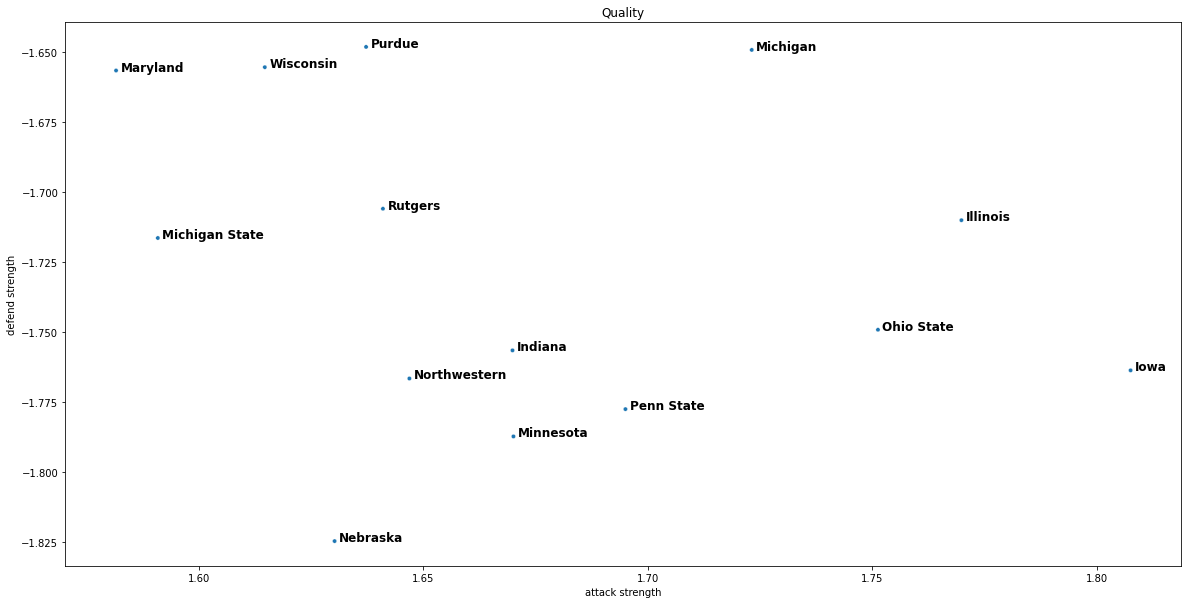

In [16]:

plt.figure(figsize=(20,10))
p1 = sns.scatterplot('attack', # Horizontal axis
       'defend', # Vertical axis
       data=qDF, # Data source
       size = 8,
       legend=False)  

for line in range(0,qDF.shape[0]):
     p1.text(qDF.attack[line]+0.001, qDF.defend[line], 
     qDF.Team[line], horizontalalignment='left', 
     size='large', color='black', weight='semibold')

plt.title('Quality')
# Set x-axis label
plt.xlabel('attack strength')
# Set y-axis label
plt.ylabel('defend strength')

In [30]:
teams

,Team,i
0,Illinois,0
1,Rutgers,1
2,Penn State,2
3,Northwestern,3
4,Indiana,4
5,Nebraska,5
6,Minnesota,6
7,Michigan State,7
8,Wisconsin,8
9,Michigan,9


In [27]:
#now get the probability of Michigan State winning vs. Michigan
#it looks like I have to do a full set of teams
#just put in a full set of combinations
#generate an array with just each team once
predictAll = df[df["split"] == "predict"]
predict = predictAll.drop(predictAll.tail(7).index,inplace=False)
predictive = Predictive(
    model=model, guide=guide, num_samples=30000, return_sites=["s1", "s2"]
)
msuMich = pd.DataFrame({'Home_id':[9,0,1,2,3,4,5,6,7,8,9,10,11,12,13],
        'Away_id':[7,0,1,2,3,4,5,6,7,8,9,10,11,12,13]})
predicted_score = predictive(
    home_id=msuMich["Home_id"].values,
    away_id=msuMich["Away_id"].values,
)


In [34]:
('a','b')[0]

'a'

(0.0, 100.0)

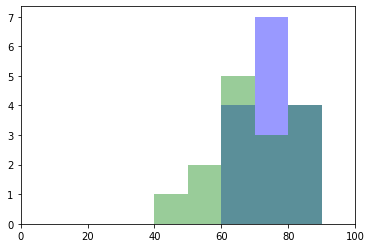

In [35]:
um = predicted_score["s1"][0].tolist()
msu = predicted_score["s2"][0].tolist()
fig, ax = plt.subplots()
for a in [(um,'b'), (msu,'g')]:
    sns.distplot(a[0], bins=range(40, 110, 10), ax=ax,color=a[1], kde=False)
ax.set_xlim([0, 100])

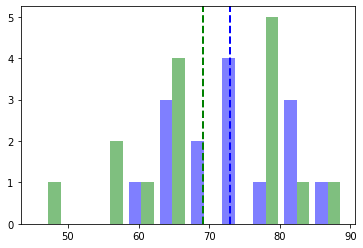

In [39]:
def meanl(lst):
    return sum(lst) / len(lst)
plt.hist([um, msu], color=['b','g'], alpha=0.5)
plt.axvline(meanl(um), color='b', linestyle='dashed', linewidth=2)
plt.axvline(meanl(msu), color='g', linestyle='dashed', linewidth=2)


In [ ]:
#work on the over under distribution
random.sample(sequence, k)



In [53]:


        score1=predicted_score["s1"].mean(axis=0).round(),
        score1error=predicted_score["s1"].std(axis=0),
        score2=predicted_score["s2"].mean(axis=0).round(),
        score2error=predicted_score["s2"].std(axis=0),
)


ValueError: Length of values (15) does not match length of index (38)

In [51]:
range(0,13)

range(0, 13)